<a href="https://colab.research.google.com/github/BharathraajNagarajan/Machine-Learning-Project---Handwritten-Digits-Classification/blob/main/ML_PROJECT_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch torchvision numpy matplotlib scipy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 57.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from math import sqrt

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving mnist_all.mat to mnist_all.mat


In [ ]:
# --------------------------------------
# Function 1: Sigmoid Activation
# --------------------------------------
def sigmoid(z):
    """Computes the sigmoid function."""
    return 1 / (1 + np.exp(-z))

# --------------------------------------
# Function 2: Preprocessing MNIST Data
# --------------------------------------
def preprocess():
    """Loads, normalizes, and splits MNIST dataset into train, validation, and test sets."""
    mat = loadmat('mnist_all.mat')  # Load dataset

    # Extract data and labels
    train_data, train_label = [], []
    test_data, test_label = [], []

    for i in range(10):
        train_data.append(mat[f'train{i}'])  # Train images
        train_label.append(np.full((mat[f'train{i}'].shape[0], 1), i))  # Train labels

        test_data.append(mat[f'test{i}'])  # Test images
        test_label.append(np.full((mat[f'test{i}'].shape[0], 1), i))  # Test labels

    train_data = np.vstack(train_data)
    train_label = np.vstack(train_label).flatten()
    test_data = np.vstack(test_data)
    test_label = np.vstack(test_label).flatten()

    # Normalize data
    train_data = train_data / 255.0
    test_data = test_data / 255.0

    # Randomly split training data into 50,000 train and 10,000 validation
    indices = np.random.permutation(train_data.shape[0])
    train_data, validation_data = train_data[indices[:50000]], train_data[indices[50000:]]
    train_label, validation_label = train_label[indices[:50000]], train_label[indices[50000:]]

    # **Feature Selection: Remove non-informative features**
    # Identify columns where all values are the same across all samples
    non_informative_features = np.all(train_data == train_data[0, :], axis=0)

    selected_features = np.where(~non_informative_features)[0]


    # Remove these columns
    train_data = train_data[:, ~non_informative_features]
    validation_data = validation_data[:, ~non_informative_features]
    test_data = test_data[:, ~non_informative_features]

    print('Preprocessing complete!')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features

# --------------------------------------
# Function 3: Initialize Weights
# --------------------------------------
def initializeWeights(n_in, n_out):
    """Initializes weight matrix with random values."""
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    return (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon

# --------------------------------------
# Function 4: Neural Network Objective Function
# --------------------------------------
def nnObjFunction(params, *args):
    """Computes loss function and gradients using forward and backpropagation."""
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    # Reshape weight matrices
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Add bias term to training data
    train_samples = training_data.shape[0]
    training_data = np.hstack((training_data, np.ones((train_samples, 1))))

    # -----------------
    # Forward Propagation
    # -----------------
    # Hidden Layer
    a_hidden = np.dot(training_data, w1.T)
    z_hidden = sigmoid(a_hidden)
    z_hidden = np.hstack((z_hidden, np.ones((z_hidden.shape[0], 1))))  # Add bias

    # Output Layer
    a_output = np.dot(z_hidden, w2.T)
    o_output = sigmoid(a_output)

    # -----------------
    # Compute Loss Function (Cross-Entropy Loss)
    # -----------------
    one_hot_labels = np.zeros((train_samples, n_class))
    one_hot_labels[np.arange(train_samples), training_label] = 1

    # Compute cross-entropy loss
    loss = -np.sum(one_hot_labels * np.log(o_output) + (1 - one_hot_labels) * np.log(1 - o_output)) / train_samples

    # Add L2 regularization to loss
    loss += (lambdaval / (2 * train_samples)) * (np.sum(w1**2) + np.sum(w2**2))  # Regularization

    # -----------------
    # Backpropagation
    # -----------------

    # Compute output layer error
    delta_output = o_output - one_hot_labels

    # Compute gradient for w2
    grad_w2 = np.dot(delta_output.T, z_hidden) / train_samples + (lambdaval * w2) / train_samples

    # Compute hidden layer error (excluding bias)
    delta_hidden = np.dot(delta_output, w2[:, :-1]) * z_hidden[:, :-1] * (1 - z_hidden[:, :-1])

    # Compute gradient for w1
    grad_w1 = np.dot(delta_hidden.T, training_data) / train_samples + (lambdaval * w1) / train_samples

    # Flatten gradients
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()), 0)

    return loss, obj_grad

# --------------------------------------
# Function 5: Predict Labels
# --------------------------------------
def nnPredict(w1, w2, data):
    """Predicts the label of input data given trained weights."""
    # Step 1: Add bias to input data
    data = np.hstack((data, np.ones((data.shape[0], 1))))  # Add bias

    # Forward Propagation
    # Step 2: Compute hidden layer activation
    a_hidden = np.dot(data, w1.T)
    z_hidden = sigmoid(a_hidden)
    z_hidden = np.hstack((z_hidden, np.ones((z_hidden.shape[0], 1))))  # Add bias

    # Step 3: Compute output layer activation
    a_output = np.dot(z_hidden, w2.T)
    o_output = sigmoid(a_output)

    # Step 4: Predicted labels (class with highest probability)
    labels = np.argmax(o_output, axis=1)
    return labels

"""**************Neural Network Script Starts here********************************"""
# --------------------------------------
# Main Execution: Train and Evaluate Model
# --------------------------------------
if __name__ == "__main__":
    # Load and preprocess data
    train_data, train_label, validation_data, validation_label, test_data, test_label = preprocess()

    # Define Network Structure
    n_input = train_data.shape[1]
    n_hidden = 50
    n_class = 10
     # Define Regularization Hyper-Parameter
    lambdaval = 0

    best_validation_accuracy = 0
    best_params = {}

    # Initialize weights
    initial_w1 = initializeWeights(n_input, n_hidden)
    initial_w2 = initializeWeights(n_hidden, n_class)
    # Unroll weight matrices into a single vector
    initial_weights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

    # Set Training Arguments
    args = (n_input, n_hidden, n_class, train_data, train_label, lambdaval)

    #  Train Neural Network
    opts = {'maxiter': 50}  # Iterations for optimization
    trained_params = minimize(nnObjFunction, initial_weights, jac=True, args=args, method='CG', options=opts)

     # Step 7: Extract Trained Weights
    w1 = trained_params.x[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = trained_params.x[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Step 8: Evaluate Model Performance
    predicted_label = nnPredict(w1, w2, train_data)
    print('\n Training Set Accuracy: {:.2f}%'.format(100 * np.mean(predicted_label == train_label)))

    predicted_label = nnPredict(w1, w2, validation_data)
    print('\n Validation Set Accuracy: {:.2f}%'.format(100 * np.mean(predicted_label == validation_label)))

    predicted_label = nnPredict(w1, w2, test_data)
    print('\n Test Set Accuracy: {:.2f}%'.format(100 * np.mean(predicted_label == test_label)))

Preprocessing complete!

 Training Set Accuracy: 94.84%

 Validation Set Accuracy: 94.06%

 Test Set Accuracy: 94.56%


Preprocessing complete!

Training Neural Network with Hidden Units = 4, Lambda = 1
Validation Accuracy: 58.66% | Training Time: 65.73 sec

Training Neural Network with Hidden Units = 4, Lambda = 21
Validation Accuracy: 73.49% | Training Time: 49.54 sec

Training Neural Network with Hidden Units = 4, Lambda = 41
Validation Accuracy: 76.93% | Training Time: 57.96 sec

Training Neural Network with Hidden Units = 12, Lambda = 1
Validation Accuracy: 90.98% | Training Time: 62.28 sec

Training Neural Network with Hidden Units = 12, Lambda = 21
Validation Accuracy: 91.43% | Training Time: 57.89 sec

Training Neural Network with Hidden Units = 12, Lambda = 41
Validation Accuracy: 90.13% | Training Time: 60.13 sec

Training Neural Network with Hidden Units = 20, Lambda = 1
Validation Accuracy: 93.57% | Training Time: 69.94 sec

Training Neural Network with Hidden Units = 20, Lambda = 21
Validation Accuracy: 92.40% | Training Time: 80.97 sec

Training Neural Network with Hidden Units = 20, Lambd

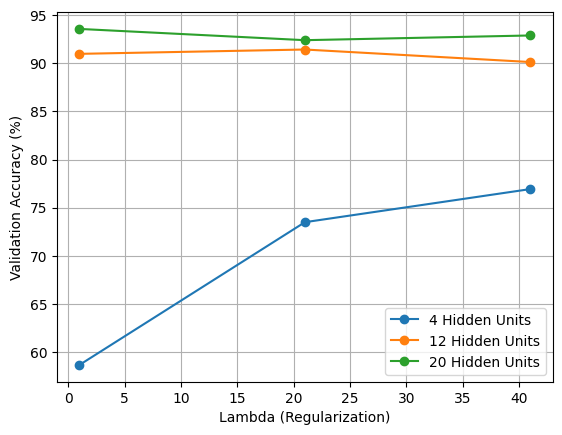

In [ ]:
import numpy as np
import pickle
from scipy.optimize import minimize
from math import sqrt
import time
import matplotlib.pyplot as plt
from scipy.io import loadmat

# --------------------------------------
# Function 1: Sigmoid Activation
# --------------------------------------
def sigmoid(z):
    """Computes the sigmoid function."""
    return 1 / (1 + np.exp(-z))

# --------------------------------------
# Function 2: Preprocessing MNIST Data
# --------------------------------------
def preprocess():
    """Loads, normalizes, and splits MNIST dataset into train, validation, and test sets."""
    mat = loadmat('mnist_all.mat')  # Load dataset

    # Extract data and labels
    train_data, train_label = [], []
    test_data, test_label = [], []

    for i in range(10):
        train_data.append(mat[f'train{i}'])  # Train images
        train_label.append(np.full((mat[f'train{i}'].shape[0], 1), i))  # Train labels

        test_data.append(mat[f'test{i}'])  # Test images
        test_label.append(np.full((mat[f'test{i}'].shape[0], 1), i))  # Test labels

    train_data = np.vstack(train_data)
    train_label = np.vstack(train_label).flatten()
    test_data = np.vstack(test_data)
    test_label = np.vstack(test_label).flatten()

    # Normalize data
    train_data = train_data / 255.0
    test_data = test_data / 255.0

    # Randomly split training data into 50,000 train and 10,000 validation
    indices = np.random.permutation(train_data.shape[0])
    train_data, validation_data = train_data[indices[:50000]], train_data[indices[50000:]]
    train_label, validation_label = train_label[indices[:50000]], train_label[indices[50000:]]

    # **Feature Selection: Remove non-informative features**
    # Identify columns where all values are the same across all samples
    non_informative_features = np.all(train_data == train_data[0, :], axis=0)

    # Save selected features
    selected_features = np.where(~non_informative_features)[0]

    # Remove these columns
    train_data = train_data[:, ~non_informative_features]
    validation_data = validation_data[:, ~non_informative_features]
    test_data = test_data[:, ~non_informative_features]

    print('Preprocessing complete!')

    return train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features

# --------------------------------------
# Function 3: Initialize Weights
# --------------------------------------
def initializeWeights(n_in, n_out):
    """Initializes weight matrix with random values."""
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    return (np.random.rand(n_out, n_in + 1) * 2 * epsilon) - epsilon

# --------------------------------------
# Function 4: Neural Network Objective Function
# --------------------------------------
def nnObjFunction(params, *args):
    """Computes loss function and gradients using forward and backpropagation."""
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args

    # Reshape weight matrices
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Add bias term to training data
    train_samples = training_data.shape[0]
    training_data = np.hstack((training_data, np.ones((train_samples, 1))))

    # -----------------
    # Forward Propagation
    # -----------------
    # Hidden Layer
    a_hidden = np.dot(training_data, w1.T)
    z_hidden = sigmoid(a_hidden)
    z_hidden = np.hstack((z_hidden, np.ones((z_hidden.shape[0], 1))))  # Add bias

    # Output Layer
    a_output = np.dot(z_hidden, w2.T)
    o_output = sigmoid(a_output)

    # -----------------
    # Compute Loss Function (Cross-Entropy Loss)
    # -----------------
    one_hot_labels = np.zeros((train_samples, n_class))
    one_hot_labels[np.arange(train_samples), training_label] = 1

    # Compute cross-entropy loss
    loss = -np.sum(one_hot_labels * np.log(o_output) + (1 - one_hot_labels) * np.log(1 - o_output)) / train_samples

    # Add L2 regularization to loss
    loss += (lambdaval / (2 * train_samples)) * (np.sum(w1**2) + np.sum(w2**2))  # Regularization

    # -----------------
    # Backpropagation
    # -----------------
    delta_output = o_output - one_hot_labels
    grad_w2 = np.dot(delta_output.T, z_hidden) / train_samples + (lambdaval * w2) / train_samples
    delta_hidden = np.dot(delta_output, w2[:, :-1]) * z_hidden[:, :-1] * (1 - z_hidden[:, :-1])
    grad_w1 = np.dot(delta_hidden.T, training_data) / train_samples + (lambdaval * w1) / train_samples

    return loss, np.concatenate((grad_w1.flatten(), grad_w2.flatten()), 0)

# --------------------------------------
# Main Execution
# --------------------------------------
if __name__ == "__main__":
    train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

    hidden_units =  [4, 12, 20]
    lambda_values = list(range(1, 61, 20))
    best_validation_accuracy = 0
    best_params = {}
    all_results = {}

    for n_hidden in hidden_units:
        for lambdaval in lambda_values:
            print(f"\nTraining Neural Network with Hidden Units = {n_hidden}, Lambda = {lambdaval}")

            initial_w1 = initializeWeights(train_data.shape[1], n_hidden)
            initial_w2 = initializeWeights(n_hidden, 10)
            initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

            start_time = time.time()
            args = (train_data.shape[1], n_hidden, 10, train_data, train_label, lambdaval)
            opts = {"maxiter": 50}
            nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method="CG", options=opts)
            train_time = time.time() - start_time

            w1 = nn_params.x[: n_hidden * (train_data.shape[1] + 1)].reshape((n_hidden, train_data.shape[1] + 1))
            w2 = nn_params.x[n_hidden * (train_data.shape[1] + 1):].reshape((10, n_hidden + 1))

            predicted_labels = nnPredict(w1, w2, validation_data)
            validation_accuracy = 100 * np.mean((predicted_labels == validation_label).astype(float))

            print(f"Validation Accuracy: {validation_accuracy:.2f}% | Training Time: {train_time:.2f} sec")

            all_results[(n_hidden, lambdaval)] = {"validation_accuracy": validation_accuracy, "train_time": train_time}

            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_params = {"n_hidden": n_hidden, "lambda": lambdaval, "w1": w1, "w2": w2, "validation_accuracy": validation_accuracy}

    with open("params.pickle", "wb") as f:
        pickle.dump({"all_results": best_params, "selected_features": selected_features.tolist()}, f)

    with open("nn_results.pkl", "wb") as f:
        pickle.dump({"all_results": all_results, "selected_features": selected_features.tolist()}, f)


    print("\nBest Model:")
    print(f"Hidden Units: {best_params['n_hidden']}, Lambda: {best_params['lambda']}")
    print(f"Validation Accuracy: {best_params['validation_accuracy']:.2f}%")

    # Plot results
    plt.figure()
    for n_hidden in hidden_units:
        plt.plot(lambda_values, [all_results[(n_hidden, l)]["validation_accuracy"] for l in lambda_values],
                 marker='o', label=f"{n_hidden} Hidden Units")
    plt.xlabel("Lambda (Regularization)")
    plt.ylabel("Validation Accuracy (%)")
    plt.legend()
    plt.grid()
    plt.show()



In [ ]:
"""FACE_NN.SCRIPT"""

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving face_all.pickle to face_all.pickle



Training Neural Network with Hidden Units = 1, Lambda = 4
Validation Accuracy: 84.17% | Training Time: 49.22 sec

Training Neural Network with Hidden Units = 1, Lambda = 12
Validation Accuracy: 85.29% | Training Time: 45.70 sec

Training Neural Network with Hidden Units = 1, Lambda = 20
Validation Accuracy: 85.03% | Training Time: 44.06 sec

Training Neural Network with Hidden Units = 21, Lambda = 4
Validation Accuracy: 83.00% | Training Time: 99.87 sec

Training Neural Network with Hidden Units = 21, Lambda = 12
Validation Accuracy: 83.45% | Training Time: 80.96 sec

Training Neural Network with Hidden Units = 21, Lambda = 20
Validation Accuracy: 84.80% | Training Time: 85.71 sec

Training Neural Network with Hidden Units = 41, Lambda = 4
Validation Accuracy: 83.30% | Training Time: 84.70 sec

Training Neural Network with Hidden Units = 41, Lambda = 12
Validation Accuracy: 83.23% | Training Time: 91.46 sec

Training Neural Network with Hidden Units = 41, Lambda = 20
Validation Accura

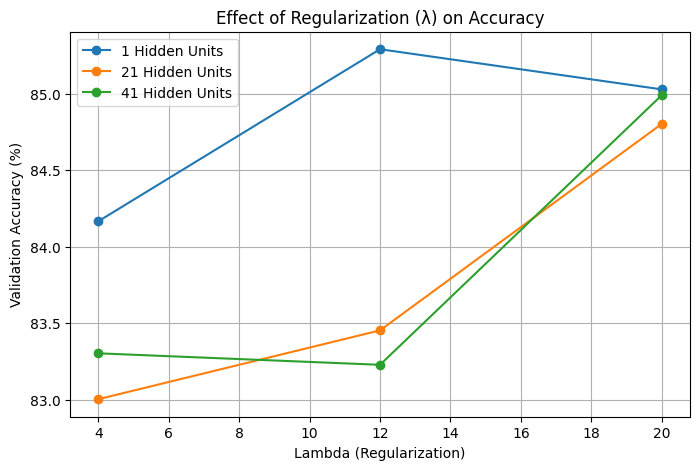

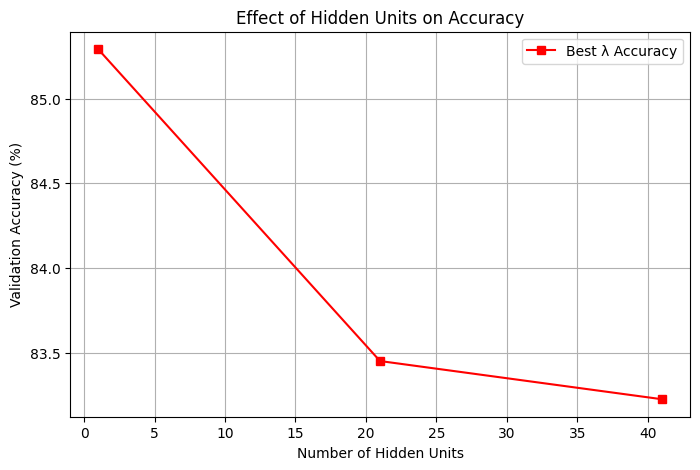

In [ ]:
'''
Comparing single layer MLP with deep MLP (using TensorFlow)
'''

import numpy as np
import pickle
from scipy.optimize import minimize
from math import sqrt
import time
start_time = time.time()


# Do not change this
def initializeWeights(n_in,n_out):
    """
    # initializeWeights return the random weights for Neural Network given the
    # number of node in the input layer and output layer

    # Input:
    # n_in: number of nodes of the input layer
    # n_out: number of nodes of the output layer

    # Output:
    # W: matrix of random initial weights with size (n_out x (n_in + 1))"""
    epsilon = sqrt(6) / sqrt(n_in + n_out + 1)
    W = (np.random.rand(n_out, n_in + 1)*2* epsilon) - epsilon
    return W



# Replace this with your sigmoid implementation
def sigmoid(z):
    """Computes the sigmoid activation function."""
    return 1 / (1 + np.exp(-z))

# Replace this with your nnObjFunction implementation
def nnObjFunction(params, *args):
    """Computes loss function and gradients using forward and backpropagation."""
    n_input, n_hidden, n_class, training_data, training_label, lambdaval = args


    # Reshape weight matrices
    w1 = params[0:n_hidden * (n_input + 1)].reshape((n_hidden, (n_input + 1)))
    w2 = params[(n_hidden * (n_input + 1)):].reshape((n_class, (n_hidden + 1)))

    # Add bias term to training data
    train_samples = training_data.shape[0]
    training_data = np.hstack((training_data, np.ones((train_samples, 1))))

    # -----------------
    # Forward Propagation
    # -----------------
    # Hidden Layer
    a_hidden = np.dot(training_data, w1.T)
    z_hidden = sigmoid(a_hidden)
    z_hidden = np.hstack((z_hidden, np.ones((z_hidden.shape[0], 1))))  # Add bias

    # Output Layer
    a_output = np.dot(z_hidden, w2.T)
    o_output = sigmoid(a_output)

    # -----------------
    # Compute Loss Function (Cross-Entropy Loss)
    # -----------------
    one_hot_labels = np.zeros((train_samples, n_class))
    one_hot_labels[np.arange(train_samples), training_label] = 1

    # Compute cross-entropy loss
    loss = -np.sum(one_hot_labels * np.log(o_output) + (1 - one_hot_labels) * np.log(1 - o_output)) / train_samples

    # Add L2 regularization to loss
    loss += (lambdaval / (2 * train_samples)) * (np.sum(w1**2) + np.sum(w2**2))  # Regularization

    # -----------------
    # Backpropagation
    # -----------------

    # Compute output layer error
    delta_output = o_output - one_hot_labels

    # Compute gradient for w2
    grad_w2 = np.dot(delta_output.T, z_hidden) / train_samples + (lambdaval * w2) / train_samples

    # Compute hidden layer error (excluding bias)
    delta_hidden = np.dot(delta_output, w2[:, :-1]) * z_hidden[:, :-1] * (1 - z_hidden[:, :-1])

    # Compute gradient for w1
    grad_w1 = np.dot(delta_hidden.T, training_data) / train_samples + (lambdaval * w1) / train_samples

    # Flatten gradients
    obj_grad = np.concatenate((grad_w1.flatten(), grad_w2.flatten()), 0)

    return loss, obj_grad

# Replace this with your nnPredict implementation
def nnPredict(w1,w2,data):
    """Predicts the label of input data given trained weights."""
    # Step 1: Add bias to input data
    data = np.hstack((data, np.ones((data.shape[0], 1))))  # Add bias

    # Forward Propagation
    # Step 2: Compute hidden layer activation
    a_hidden = np.dot(data, w1.T)
    z_hidden = sigmoid(a_hidden)
    z_hidden = np.hstack((z_hidden, np.ones((z_hidden.shape[0], 1))))  # Add bias

    # Step 3: Compute output layer activation
    a_output = np.dot(z_hidden, w2.T)
    o_output = sigmoid(a_output)

    # Step 4: Predicted labels (class with highest probability)
    labels = np.argmax(o_output, axis=1)
    return labels

# Do not change this
def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = labels[0]
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]
    selected_features = np.var(train_x, axis=0) > 0.01
    return train_x, train_y, valid_x, valid_y, test_x, test_y, selected_features

"""**************Neural Network Script Starts here********************************"""
if __name__ == "__main__":
    # Load and preprocess the dataset
    train_data, train_label, validation_data, validation_label, test_data, test_label, selected_features = preprocess()

    # Define network architecture
    n_input = train_data.shape[1]
    hidden_units  = list(range(1, 61, 20))
    n_class = 2  # Since CelebA data is binary (wearing glasses or not)
    lambda_values  = [4,  12,  20]  # Regularization hyperparameter

    best_validation_accuracy = 0
    best_params = {}

    all_results = {}

    for n_hidden in hidden_units:
        for lambdaval in lambda_values:
            print(f"\nTraining Neural Network with Hidden Units = {n_hidden}, Lambda = {lambdaval}")

            # Initialize Weights
            initial_w1 = initializeWeights(train_data.shape[1], n_hidden)
            initial_w2 = initializeWeights(n_hidden, 2)
            initialWeights = np.concatenate((initial_w1.flatten(), initial_w2.flatten()), 0)

            # Train the Neural Network
            start_time = time.time()
            args = (train_data.shape[1], n_hidden, 2, train_data, train_label, lambdaval)
            opts = {"maxiter": 50}
            nn_params = minimize(nnObjFunction, initialWeights, jac=True, args=args, method="CG", options=opts)
            train_time = time.time() - start_time

            # Extract weights
            w1 = nn_params.x[: n_hidden * (train_data.shape[1] + 1)].reshape((n_hidden, train_data.shape[1] + 1))
            w2 = nn_params.x[n_hidden * (train_data.shape[1] + 1) :].reshape((2, n_hidden + 1))

            # Get validation accuracy
            predicted_labels = nnPredict(w1, w2, validation_data)
            validation_accuracy = 100 * np.mean((predicted_labels == validation_label).astype(float))

            print(f"Validation Accuracy: {validation_accuracy:.2f}% | Training Time: {train_time:.2f} sec")

            # Store results
            all_results[(n_hidden, lambdaval)] = {
                "validation_accuracy": validation_accuracy,
                "train_time": train_time,
                "w1": w1,
                "w2": w2,
                "lambda": lambdaval,
                "hidden_units": n_hidden,
                "selected_features": selected_features
            }

            # Check if best model
            if validation_accuracy > best_validation_accuracy:
                best_validation_accuracy = validation_accuracy
                best_params = {
                    "n_hidden": n_hidden,
                    "lambda": lambdaval,
                    "w1": w1,
                    "w2": w2,
                    "validation_accuracy": validation_accuracy,
                    "selected_features": selected_features
                }

    # Save Best Model Parameters
    with open("params.pickle", "wb") as f:
        pickle.dump(best_params, f)

    # Save All Results
    with open("face_nn_results.pkl", "wb") as f:
        pickle.dump(all_results, f)

    print("\nBest Model:")
    print(f"Hidden Units: {best_params['n_hidden']}, Lambda: {best_params['lambda']}")
    print(f"Validation Accuracy: {best_params['validation_accuracy']:.2f}%")

    # Plot Lambda vs Accuracy
    plt.figure(figsize=(8,5))
    for h in hidden_units:
        accuracies = [all_results[(h, l)]["validation_accuracy"] for l in lambda_values]
        plt.plot(lambda_values, accuracies, marker='o', linestyle='-', label=f"{h} Hidden Units")

    plt.xlabel("Lambda (Regularization)")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Effect of Regularization (λ) on Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Hidden Units vs Accuracy
    plt.figure(figsize=(8,5))
    best_lambdas = [best_params["lambda"] for h in hidden_units]
    best_accuracies = [all_results[(h, best_params["lambda"])]["validation_accuracy"] for h in hidden_units]

    plt.plot(hidden_units, best_accuracies, marker='s', linestyle='-', color='r', label="Best λ Accuracy")
    plt.xlabel("Number of Hidden Units")
    plt.ylabel("Validation Accuracy (%)")
    plt.title("Effect of Hidden Units on Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
"""DNN"""

Using cpu device

Training DNN with 4 hidden layers, LR = 0.5...

loss: 0.745317  [    0/21100]
loss: 0.679482  [10000/21100]
loss: 0.683468  [20000/21100]
loss: 0.633929  [    0/21100]
loss: 0.679811  [10000/21100]
loss: 0.579621  [20000/21100]
loss: 0.604199  [    0/21100]
loss: 0.490106  [10000/21100]
loss: 0.532823  [20000/21100]
loss: 0.459516  [    0/21100]
loss: 0.508450  [10000/21100]
loss: 0.568876  [20000/21100]
loss: 0.552677  [    0/21100]
loss: 0.710607  [10000/21100]
loss: 1.155909  [20000/21100]
loss: 0.676011  [    0/21100]
loss: 0.578732  [10000/21100]
loss: 0.719311  [20000/21100]
loss: 0.694238  [    0/21100]
loss: 0.823682  [10000/21100]
loss: 0.447422  [20000/21100]
loss: 0.601316  [    0/21100]
loss: 0.563935  [10000/21100]
loss: 0.521262  [20000/21100]
loss: 0.657409  [    0/21100]
loss: 0.589094  [10000/21100]
loss: 0.661757  [20000/21100]
loss: 0.673075  [    0/21100]
loss: 0.512562  [10000/21100]
loss: 0.486617  [20000/21100]
Test Accuracy with 4 layers, LR = 

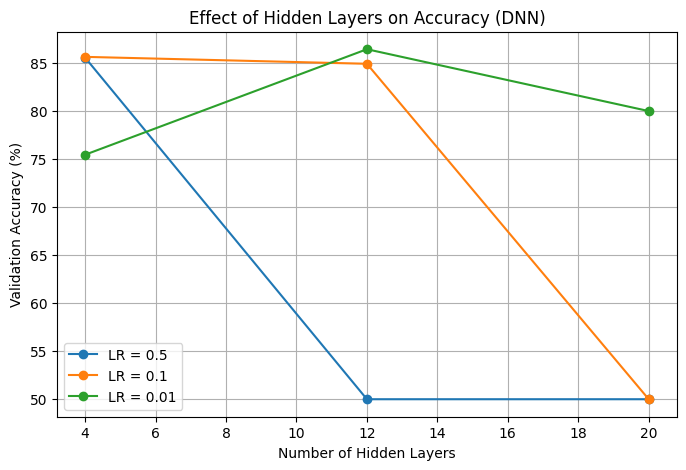

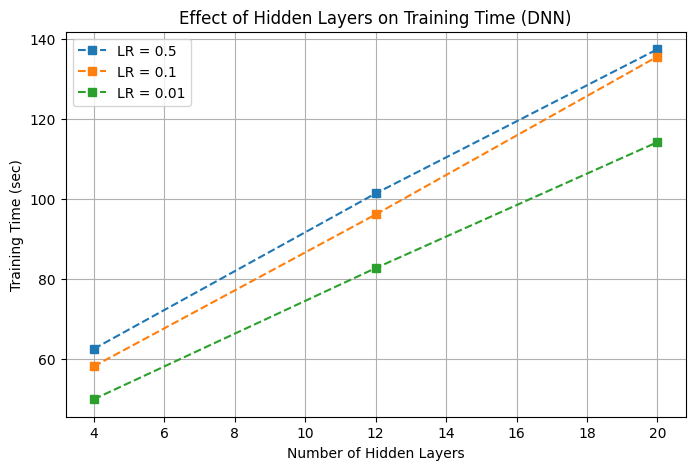

In [ ]:
'''
Comparing single layer MLP with deep MLP (using PyTorch)
'''

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pickle
import time


# Create model
# Add more hidden layers to create deeper networks
# Remember to connect the final hidden layer to the out_layer
def create_multilayer_perceptron(num_layers):
    """
    Creates a multi-layer perceptron (MLP) with the given number of hidden layers.

    Parameters:
    num_layers (int): Number of hidden layers (e.g., 3, 5, or 7)

    Returns:
    PyTorch model instance
    """

    class net(nn.Module):
        def __init__(self,num_layers):
            super(net, self).__init__()

            # Network Parameters
            self.n_hidden = 256  # Number of neurons in each hidden layer
            self.n_input = 2376  # Data input
            self.n_classes = 2   # Output classes

            # Initialize network layers dynamically
            self.layers = nn.ModuleList()

            # First hidden layer (input to first hidden)
            self.layers.append(nn.Sequential(
                nn.Linear(self.n_input, self.n_hidden),
                nn.BatchNorm1d(self.n_hidden),
                nn.ReLU(),
                nn.Dropout(0.3)
            ))

            # Adding additional hidden layers based on num_layers parameter
            for _ in range(num_layers - 1):
                self.layers.append(nn.Sequential(
                    nn.Linear(self.n_hidden, self.n_hidden),
                    nn.BatchNorm1d(self.n_hidden),
                    nn.ReLU(),
                    nn.Dropout(0.3)
                ))

            # Output layer
            self.out_layer = nn.Linear(self.n_hidden, self.n_classes)

        def forward(self, x):
            for layer in self.layers:
                x = layer(x)
            x = self.out_layer(x)
            return x
    return net(num_layers)

# Do not change this
def preprocess():
    pickle_obj = pickle.load(file=open('face_all.pickle', 'rb'))
    features = pickle_obj['Features']
    labels = pickle_obj['Labels']
    train_x = features[0:21100] / 255
    valid_x = features[21100:23765] / 255
    test_x = features[23765:] / 255

    labels = np.squeeze(labels)
    train_y = labels[0:21100]
    valid_y = labels[21100:23765]
    test_y = labels[23765:]

    class dataset(Dataset):
        def __init__(self, X, y):
            self.X = X
            self.y = y

        def __len__(self):
            return len(self.y)

        def __getitem__(self, idx):
            return self.X[idx], self.y[idx]

    trainset = dataset(train_x, train_y)
    validset = dataset(valid_x, valid_y)
    testset = dataset(test_x, test_y)

    return trainset, validset, testset


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn,num_layers,train_time, lr):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    accuracy = 100 * correct

    print(f"Test Accuracy with {num_layers} layers, LR = {lr}: {accuracy:.2f}% | Training Time: {train_time:.2f} sec")

    dnn_results = {
        f"dnn_{num_layers}_layers_lr_{lr}_accuracy": accuracy,
        f"dnn_{num_layers}_layers_lr_{lr}_loss": test_loss,
        f"dnn_{num_layers}_layers_lr_{lr}_train_time": train_time
    }

    # Save results to a pickle file
    try:
        with open("dnn_results.pkl", "rb") as f:
            existing_data = pickle.load(f)
    except (FileNotFoundError, EOFError):
        existing_data = {}

    # Update existing data
    existing_data.update(dnn_results)

    # Write back to the file
    with open("dnn_results.pkl", "wb") as f:
        pickle.dump(existing_data, f)




    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return accuracy

# Parameters
learning_rates = [0.5, 0.1, 0.01]
hidden_layers = [4, 12, 20]
training_epochs = 10  # Increased epochs for better learning
batch_size = 100

# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")



# load data
trainset, validset, testset = preprocess()
train_dataloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(validset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(testset, batch_size=batch_size, shuffle=False)


# Store best model parameters
best_accuracy = 0
best_config = {}

results = []

for lr in learning_rates:
    for layers in hidden_layers:
        print(f"\nTraining DNN with {layers} hidden layers, LR = {lr}...\n")

        model = create_multilayer_perceptron(layers).to(device)
        cost = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        start_time = time.time()

        for epoch in range(training_epochs):
            train(train_dataloader, model, cost, optimizer)

        train_time = time.time() - start_time

        accuracy = test(test_dataloader, model, cost, layers,  train_time, lr)

        results.append({"Layers": layers, "LR": lr, "Accuracy": accuracy, "TrainTime": train_time})

        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_config = {
                "Layers": layers,
                "Learning Rate": lr,
                "Accuracy": accuracy,
                "Training Time": train_time
            }

print("\nBest Model:")
print(f"Layers: {best_config['Layers']}, Learning Rate: {best_config['Learning Rate']}")
print(f"Training Time: {best_config['Training Time']:.2f} sec")
print(f"Test Accuracy: {best_config['Accuracy']:.2f}%")

with open("dnn_results.pkl", "wb") as f:
    pickle.dump(best_config, f)

# Plot Accuracy vs. Number of Layers
plt.figure(figsize=(8,5))
for lr in learning_rates:
    filtered_results = [res for res in results if res["LR"] == lr]
    layers = [res["Layers"] for res in filtered_results]
    acc = [res["Accuracy"] for res in filtered_results]
    plt.plot(layers, acc, marker="o", label=f"LR = {lr}")

plt.xlabel("Number of Hidden Layers")
plt.ylabel("Validation Accuracy (%)")
plt.title("Effect of Hidden Layers on Accuracy (DNN)")
plt.legend()
plt.grid()
plt.show()

# Plot Training Time vs. Number of Layers
plt.figure(figsize=(8,5))
for lr in learning_rates:
    filtered_results = [res for res in results if res["LR"] == lr]
    layers = [res["Layers"] for res in filtered_results]
    times = [res["TrainTime"] for res in filtered_results]
    plt.plot(layers, times, marker="s", linestyle="--", label=f"LR = {lr}")

plt.xlabel("Number of Hidden Layers")
plt.ylabel("Training Time (sec)")
plt.title("Effect of Hidden Layers on Training Time (DNN)")
plt.legend()
plt.grid()
plt.show()

In [ ]:
"""Run the deep neural network code we provided and compare the results with normal neural network."""

In [ ]:
import pickle
import pandas as pd

# Load face_nn results
with open("face_nn_results.pkl", "rb") as f:
    face_nn_results = pickle.load(f)

# Load DNN results
try:
    with open("dnn_results.pkl", "rb") as f:
        dnn_results = pickle.load(f)
except FileNotFoundError:
    dnn_results = {}

# Extracting Face_NN results
face_nn_comparison = []
for (hidden_units, lambdaval), values in face_nn_results.items():
    face_nn_comparison.append({
        "Model": "Face_NN",
        "Hidden Layers": hidden_units,
        "Test Accuracy (%)": values.get("test_accuracy", 0.0),  # Ensure test accuracy is recorded
        "Training Time (sec)": values["train_time"]
    })

# Extracting DNN results
dnn_comparison = []
for key, values in dnn_results.items():
    if "accuracy" in key:  # Ensure test accuracy key is extracted correctly
        layers = int(key.split("_")[1])  # Extract number of hidden layers
        dnn_comparison.append({
            "Model": "DNN",
            "Hidden Layers": layers,
            "Test Accuracy (%)": values,  # Accuracy is stored directly
            "Training Time (sec)": dnn_results.get(f"dnn_{layers}_layers_lr_0.01_train_time", 0.0)
        })

# Combine results
comparison_df = pd.DataFrame(face_nn_comparison + dnn_comparison)

# Print table
print("Comparison of Face_NN vs DNN:\n")
print(comparison_df.to_string(index=False))


Comparison of Face_NN vs DNN:

  Model  Hidden Layers  Test Accuracy (%)  Training Time (sec)
Face_NN              1                0.0            49.215272
Face_NN              1                0.0            45.701486
Face_NN              1                0.0            44.062115
Face_NN             21                0.0            99.870279
Face_NN             21                0.0            80.957685
Face_NN             21                0.0            85.713815
Face_NN             41                0.0            84.695913
Face_NN             41                0.0            91.459224
Face_NN             41                0.0            92.676185


In [ ]:
"""CNN"""

Using cpu device

Running CNN with 1 iterations...

loss: 2.304266  [    0/60000]
loss: 1.220672  [ 6400/60000]
loss: 0.567819  [12800/60000]
loss: 0.524958  [19200/60000]
loss: 0.239225  [25600/60000]
loss: 0.243371  [32000/60000]
loss: 0.292187  [38400/60000]
loss: 0.329333  [44800/60000]
loss: 0.322097  [51200/60000]
loss: 0.290060  [57600/60000]
Time usage: 0:00:58

Debug: About to call test() function
Test Error: 
 Accuracy: 93.8%, Avg loss: 0.208644 

Example errors:


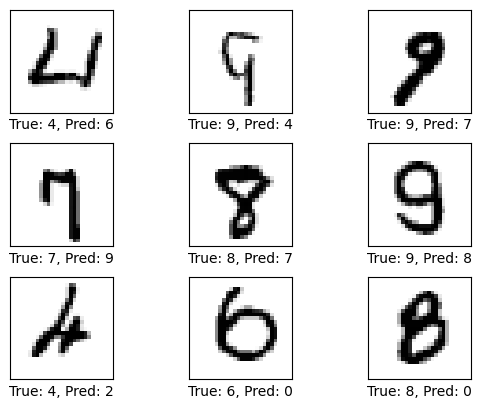

Confusion Matrix:
[[ 969    0    2    2    0    1    3    1    2    0]
 [   0 1115    4    2    1    1    3    0    9    0]
 [  10    1  975    8   10    0    3   11   13    1]
 [   3    1   22  947    0    7    0   16   12    2]
 [   1    2    5    1  941    0    7    2    3   20]
 [  11    1    4   35    7  803   14    2   12    3]
 [  14    3    4    1   10   10  914    1    1    0]
 [   0    6   28    4    5    0    0  954    1   30]
 [  16    2   11   25   15   10    6   11  866   12]
 [  12    5    7   14   47    2    0   22    8  892]]


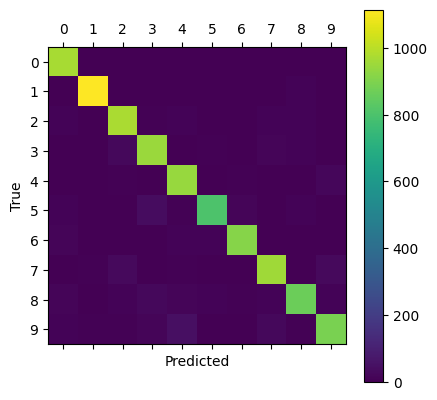


Debug: test() function executed

Running CNN with 9 iterations...

loss: 0.181094  [    0/60000]
loss: 0.219846  [ 6400/60000]
loss: 0.380104  [12800/60000]
loss: 0.087506  [19200/60000]
loss: 0.136921  [25600/60000]
loss: 0.124753  [32000/60000]
loss: 0.116060  [38400/60000]
loss: 0.154569  [44800/60000]
loss: 0.143457  [51200/60000]
loss: 0.140682  [57600/60000]
loss: 0.142151  [    0/60000]
loss: 0.072955  [ 6400/60000]
loss: 0.157948  [12800/60000]
loss: 0.156031  [19200/60000]
loss: 0.197886  [25600/60000]
loss: 0.115698  [32000/60000]
loss: 0.064873  [38400/60000]
loss: 0.041652  [44800/60000]
loss: 0.051524  [51200/60000]
loss: 0.204785  [57600/60000]
loss: 0.023406  [    0/60000]
loss: 0.153739  [ 6400/60000]
loss: 0.098258  [12800/60000]
loss: 0.075363  [19200/60000]
loss: 0.065341  [25600/60000]
loss: 0.029203  [32000/60000]
loss: 0.014719  [38400/60000]
loss: 0.057314  [44800/60000]
loss: 0.057806  [51200/60000]
loss: 0.086393  [57600/60000]
loss: 0.036309  [    0/60000]
lo

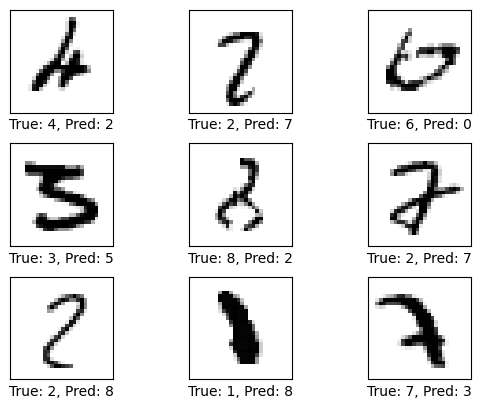

Confusion Matrix:
[[ 972    0    0    0    0    1    2    1    3    1]
 [   0 1130    3    0    0    0    1    0    1    0]
 [   2    1 1020    0    1    0    0    4    4    0]
 [   0    0    2  987    0   13    0    3    4    1]
 [   0    0    3    0  968    0    1    0    2    8]
 [   2    0    0    1    0  883    2    0    2    2]
 [   2    3    0    0    2    2  946    0    3    0]
 [   0    2    7    1    0    0    0 1012    1    5]
 [   2    0    3    2    1    1    0    2  958    5]
 [   0    6    0    0    3    3    0    3    0  994]]


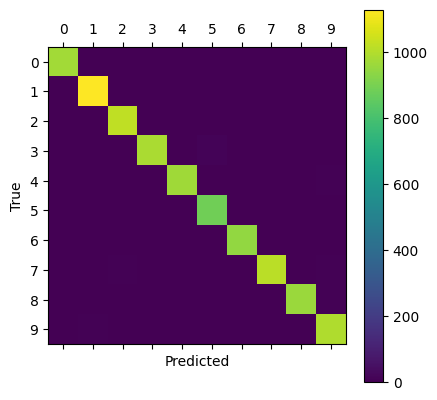


Debug: test() function executed

Best CNN Model: Accuracy = 98.70%, Training Time = 496.75 sec


In [ ]:
# matplotlib inline
import matplotlib.pyplot as plt
import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import pickle

# We know that MNIST images are 28 pixels in each dimension.
img_size = 28

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

def create_cnn():
    class cnn(nn.Module):
        def __init__(self):
            super().__init__()

            # Convolutional Layer 1
            filter_size1 = 5
            num_filters1 = 16

            # Convolutional Layer 2
            filter_size2 = 5
            num_filters2 = 36

            # Fully-connected layer
            fc_size = 128

            # Number of color channels for the images: 1 for gray-scale.
            num_channels = 1

            # Number of classes, one class for each of 10 digits.
            num_classes = 10

            self.layer_conv1 = nn.Conv2d(num_channels, num_filters1, (filter_size1, filter_size1), padding='same')
            self.layer_conv2 = nn.Conv2d(num_filters1, num_filters2, (filter_size2, filter_size2), padding='same')
            self.pool = nn.MaxPool2d(2)
            self.layer_fc1 = nn.Linear(1764, fc_size)
            self.layer_fc2 = nn.Linear(fc_size, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.layer_conv1(x)))
            x = self.pool(F.relu(self.layer_conv2(x)))
            x = torch.flatten(x, 1)
            x = F.relu(self.layer_fc1(x))
            x = self.layer_fc2(x)
            return x

    return cnn()


def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X.float())
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9

    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].cpu().numpy().squeeze(), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = f"True: {cls_true[i].item()}"
        else:
            xlabel = f"True: {cls_true[i].item()}, Pred: {cls_pred[i].item()}"

        ax.set_xlabel(xlabel)
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()


def plot_confusion_matrix(cls_pred, cls_true):
    cm = confusion_matrix(y_true=cls_true, y_pred=cls_pred)
    print(cm)
    plt.matshow(cm)
    plt.colorbar()
    tick_marks = np.arange(10)
    plt.xticks(tick_marks, range(10))
    plt.yticks(tick_marks, range(10))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()


def test(dataloader, model, loss_fn, show_example_errors=False, show_confusion_matrix=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0

    mis_example, mis_example_pred, mis_example_true = [], [], []
    y_true, y_pred = [], []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X.float())
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

            mis_example.extend(X[(pred.argmax(1) == y) == False])
            mis_example_pred.extend(pred[(pred.argmax(1) == y) == False].argmax(1))
            mis_example_true.extend(y[(pred.argmax(1) == y) == False])

            y_true.extend(y.cpu().numpy())
            y_pred.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    correct /= size
    test_accuracy = 100 * correct
    print(f"Test Error: \n Accuracy: {test_accuracy:>0.1f}%, Avg loss: {test_loss:>8f} \n")

    if show_example_errors:
        print("Example errors:")
        plot_images(images=mis_example[:9], cls_true=mis_example_true[:9], cls_pred=mis_example_pred[:9])

    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=y_pred, cls_true=y_true)

    return test_accuracy


def optimize(iterations, train_dataloader, model, cost, optimizer):
    start_time = time.time()
    for _ in range(iterations):
        train(train_dataloader, model, cost, optimizer)
    end_time = time.time()

    time_dif = end_time - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

    return time_dif

learning_rate = 1e-4
train_batch_size = 64
test_batch_size = 256

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = create_cnn().to(device)
cost = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Load MNIST dataset
trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
testset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor())
train_dataloader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
test_dataloader = DataLoader(testset, batch_size=test_batch_size, shuffle=False)

best_accuracy = 0
best_train_time = float('inf')  # Set to a high number initially

cnn_results = {}

for iterations in [1, 9]:  #900, 9000
    print(f"\nRunning CNN with {iterations} iterations...\n")

    cnn_train_time = optimize(iterations, train_dataloader, model, cost, optimizer)
    print("\nDebug: About to call test() function")

    cnn_accuracy = test(test_dataloader, model, cost, show_example_errors=True, show_confusion_matrix=True)
    print("\nDebug: test() function executed")


    # Store results
    cnn_results[f"cnn_{iterations}_iterations_accuracy"] = cnn_accuracy
    cnn_results[f"cnn_{iterations}_iterations_train_time"] = cnn_train_time

    # Track the best accuracy
    if cnn_accuracy > best_accuracy:
        best_accuracy = cnn_accuracy
        best_train_time = cnn_train_time

# Store best accuracy for comparison
cnn_results["best_accuracy"] = best_accuracy
cnn_results["best_train_time"] = best_train_time

# Save results to pickle file
with open("cnn_results.pkl", "wb") as f:
    pickle.dump(cnn_results, f)

print(f"\nBest CNN Model: Accuracy = {best_accuracy:.2f}%, Training Time = {best_train_time:.2f} sec")

In [ ]:
"""Compare the performance of the deep Neural Networks vs. Convolutional Neural Networks in terms
 of accuracy on test data and training time. """